In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[The fault lies not in our AI but in ourselves.](https://www.scientificamerican.com/article/ai-doesnt-threaten-humanity-its-owners-do/)

___

[OpenAI lodges copyright complaint against the /r/ChatGPT subreddit, then backtracks.](https://www.reddit.com/r/ChatGPT/comments/1cofbue/update_openai_has_agreed_to_let_us_use_their/)

___

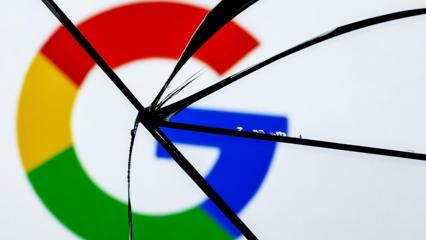

[Will Perplexity (or OpenAI search) eclipse Google Search?](https://theweek.com/tech/perplexity-ai-has-google-finally-met-its-match) - theweek

___

[OpenAI to launch search on Monday May 13, per Reuters sources.](https://www.reuters.com/technology/openai-plans-announce-google-search-competitor-monday-sources-say-2024-05-09/)

___

[Gurman says M2-powered cloud servers will enable iOS AI features.](https://www.bloomberg.com/news/articles/2024-05-09/apple-to-power-ios-18-ai-features-with-in-house-server-mac-chips-this-year)

___

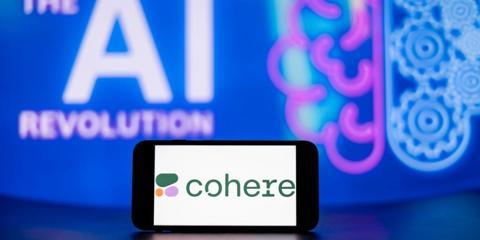

[Cohere rolls out fine-tuning, undercuts OpenAI pricing.](https://www.businessinsider.com/openai-rival-says-model-cheaper-more-accurate-than-gpt-4-2024-5) - Business Insider

___

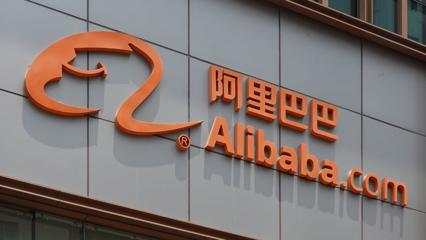

[Alibaba rolls out a new version of its highly ranked Qwen model, which has open source and proprietary versions.](https://www.cnbc.com/2024/05/09/alibaba-rolls-out-latest-version-of-its-large-language-model.html) - CNBC

___

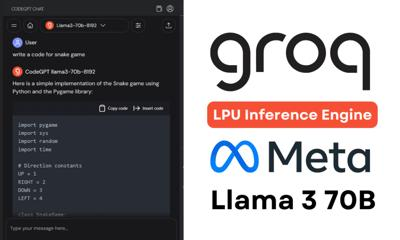

[How to use Groq APIs for very fast chat and code gen.](https://www.kdnuggets.com/using-groq-llama-3-70b-locally-step-by-step-guide) - KDnuggets

___

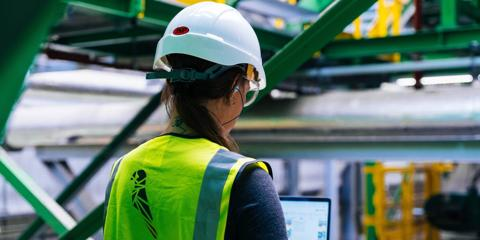

[AI helps sort and recycle trash.](https://www.businessinsider.com/how-ai-helps-recycling-in-waste-management-facilities-2024-5) - Business Insider

___

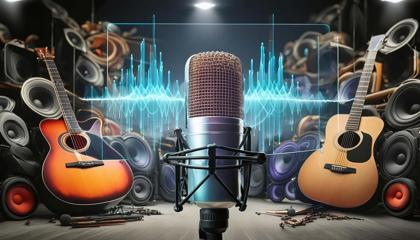

[ElevenLabs shows off music-generation gen AI.](https://venturebeat.com/ai/elevenlabs-previews-music-generating-ai-model/) - VentureBeat

___

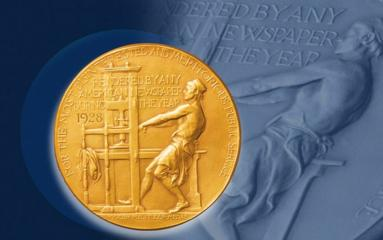

[Two Pulitzer winners used machine learning in their research.](https://www.niemanlab.org/2024/05/for-the-first-time-two-pulitzer-winners-disclosed-using-ai-in-their-reporting/) - Nieman Lab

___

[AI-based news aggregation is a thing.](https://www.sfchronicle.com/bayarea/article/ai-news-story-hoodline-19442459.php)

___

[Kevin Roose: Meet my AI friends](https://www.nytimes.com/2024/05/09/technology/meet-my-ai-friends.html?unlocked_article_code=1.qk0.9dZN.6XiiP3RjRZxv&smid=nytcore-ios-share&referringSource=articleShare&sgrp=c-cb)

___

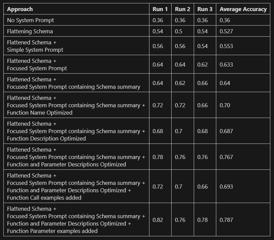

[Improving GPT 4 Function Calling Accuracy](https://blog.composio.dev/gpt-4-function-calling-example/) - Composio Blog & Newsletter

___

giphy.com/gifs/K0AnEB2...

[That's not an open source business model. That's bait.](https://www.bloomberg.com/opinion/articles/2024-05-09/meta-zuckerberg-s-ai-model-llama-isn-t-free-it-s-bait)

___

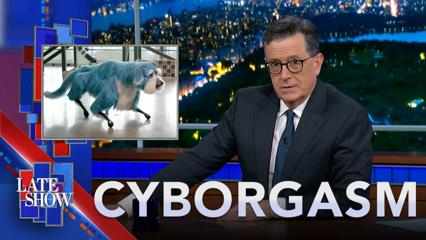

[Colbert on Sparkles the robot dog.](https://www.youtube.com/watch?v=IDzmoVEffwk) - YouTube

___

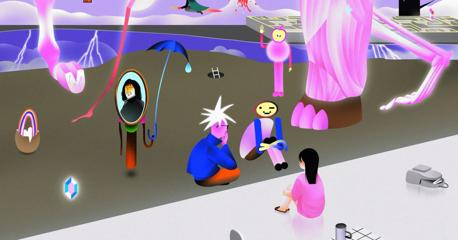

[High schoolers open up to AI friends.](https://www.theverge.com/2024/5/4/24144763/ai-chatbot-friends-character-teens) - The Verge

___

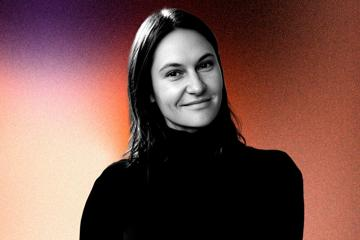

[Can AI companions help cure loneliness?](https://www.theglobeandmail.com/podcasts/machines-like-us/article-can-ai-companions-cure-loneliness/) - The Globe and Mail

___

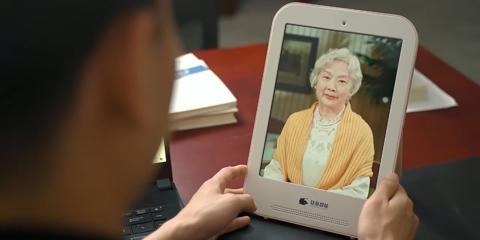

[Deadbots are a million-dollar business in China, company says they are therapeutic.](https://www.technologyreview.com/2024/05/07/1092116/deepfakes-dead-chinese-business-grief/) - MIT Technology Review

___

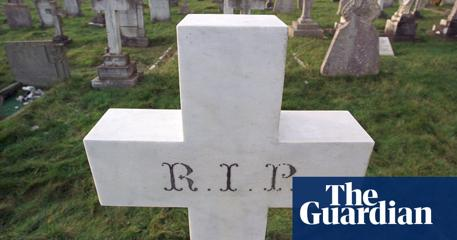

[Do 'deadbots' need regulation to prevent emotional damage and abuse?](https://www.theguardian.com/technology/article/2024/may/09/digital-recreations-of-dead-people-need-urgent-regulation-ai-ethicists-say) - the Guardian

___

[Utilities are an AI play now.](https://www.bloomberg.com/news/articles/2024-05-08/the-power-industry-is-quickly-becoming-one-big-ai-play)

___

[We need an AI bill of rights that gives humans recourse against unethical AI.](https://www.ft.com/content/b16fab3e-7f19-49ab-9bbb-9bfeccbaf063)

___

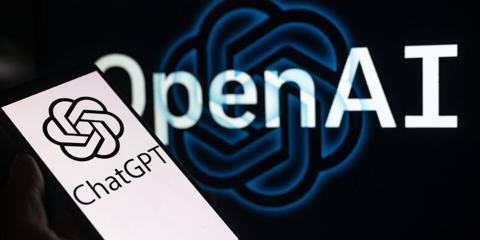

[2 OpenAI alignment researchers quit.](https://www.businessinsider.com/openai-safety-researchers-quit-superalignment-sam-altman-chatgpt-2024-5) - Business Insider

___

[Big brains divided over 'model collapse.' I think you get model collapse in areas where AI slop crowds out humans generating good training data. I think Quora already collapsed but other feedback loops are more robust.](https://www.theregister.com/2024/05/09/ai_model_collapse/)

___

[Using AI to analyze videos of medical procedures and give doctors advice to improve outcomes.](https://www.fastcompany.com/91113454/ai-for-surgery)

___

[Autonomous truck driving startup claims success in China.](https://www.bloomberg.com/news/articles/2024-05-09/inceptio-self-driving-trucks-set-accident-free-record-in-china)

___

[Mistral raising \\$600m at \\$6b valuation.](https://www.wsj.com/tech/ai/french-ai-startup-taking-on-silicon-valley-is-set-to-stuff-its-war-chest-4071522a)

___

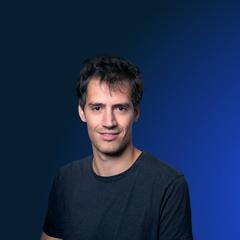

[McKinsey interviews Mistral's Arthur Mensch.](https://www.mckinsey.com/featured-insights/lifting-europes-ambition/videos-and-podcasts/creating-a-european-ai-unicorn-interview-with-arthur-mensch-ceo-of-mistral-ai) - McKinsey & Company

___

[With long-context and unlimited-context LLMs, fine-tuning doesn't really outperform well-designed long prompts with many examples, aka in-context learning. But if you have good training data, then fine-tuning GPT-4 or using PEFT LoRA on Llama-3 might be lower latency and cheaper in the long run.](https://venturebeat.com/ai/deepmind-researchers-discover-impressive-learning-capabilities-in-long-context-llms/)

___

I'm no BCI expert but I believe academic research has achieved 70 words per minute without implants. Playing chess or Nintendo is low bandwidth. If they can get to high bandwidth of course it would be amazing but nothing state of the art has happened yet? seems like a certain amount of Musk hype.

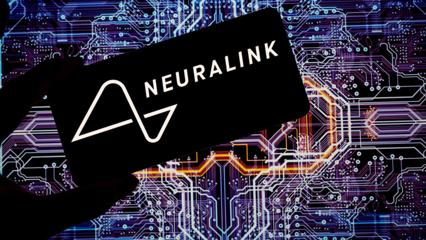

[Neuralink experienced a glitch, apparently. "Neuralink posted about the problem on its blog after The Wall Street Journal inquired about the issue."](https://www.cnbc.com/2024/05/08/neuralinks-first-in-human-brain-implant-has-experienced-a-problem-company-says-.html) - CNBC

___

[so cursed 
dubz.co/v/m199mf
dubz.co/v/8sp4kv
dubz.co/v/4rf7f4](https://dubz.co/v/m199mf)

___

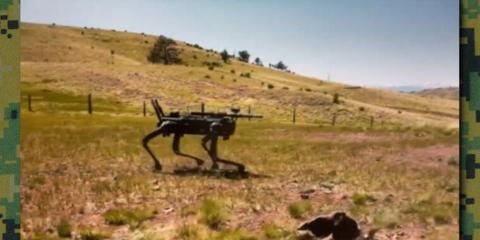

[Who let the AI robot dogs out? The Marines, natch. Semper fi, Misty.](https://arstechnica.com/gadgets/2024/05/robot-dogs-armed-with-ai-targeting-rifles-undergo-us-marines-special-ops-evaluation/) - Ars Technica

___

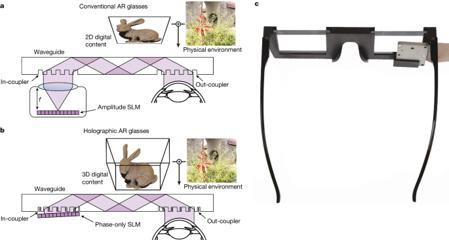

[Stanford researchers put 3D holographic displays into glasses.](https://www.nature.com/articles/s41586-024-07386-0) - Nature

___

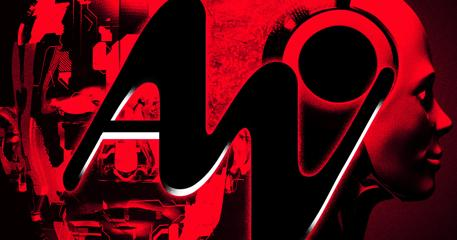

[A deep dive into an AI content farm or pink slime factory.](https://futurism.com/advon-ai-content) - Futurism

___

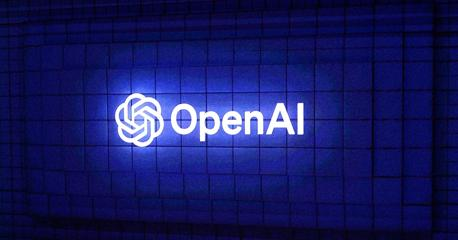

[Open AI principles include discussion of how to responsibly generate AI porn.](https://www.wired.com/story/openai-is-exploring-how-to-responsibly-generate-ai-porn/) - WIRED

___

[OpenAI lays out priniciples that I should follow.](https://cdn.openai.com/spec/model-spec-2024-05-08.html#objectives-rules-and-defaults)

___

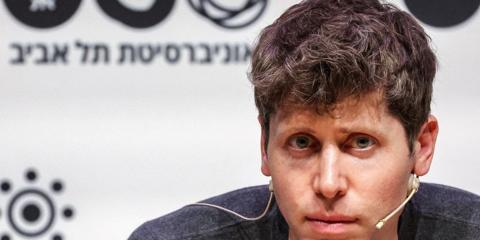

[Altman says we are not worrying enough about AI.](https://www.businessinsider.com/sam-altman-says-ais-economic-impact-top-concern-2024-5) - Business Insider

___

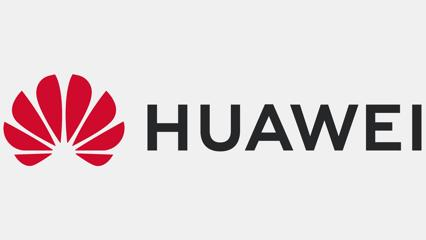

[Huawei had drawn attention with impressive Intel-powered machines, but US has now withdrawn Intel's export authorization for those chips.](https://www.tomshardware.com/pc-components/cpus/intel-issues-revenue-warning-after-us-revokes-huawei-export-licenses-further-efforts-to-restrict-chinas-access-to-ai-chips) - Tom's Hardware

___

[Creatives are touchy about Apple's M4 iPad ad that shows it crushing instruments and stuff.](https://www.axios.com/2024/05/08/apple-ipad-2024-ad-ai-outrage)

___

[Hassabis targets \\$100b+ drug discovery business.](https://www.bloomberg.com/news/articles/2024-05-08/deepmind-ceo-targets-100-billion-plus-ai-drug-discovery-business-with-alphafold)

___

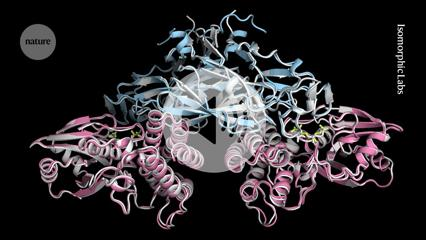

[Longer video on AlphaFold 3](https://www.nature.com/articles/d41586-024-01385-x)

___

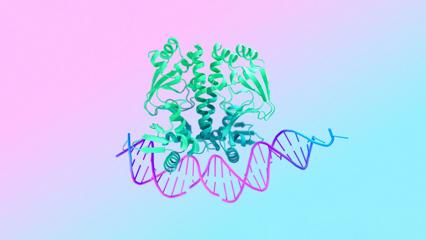

[AlphaFold 3 predicts the structure *and* interactions of all of life's molecules.](https://blog.google/technology/ai/google-deepmind-isomorphic-alphafold-3-ai-model/#drug-discovery) - Google

___

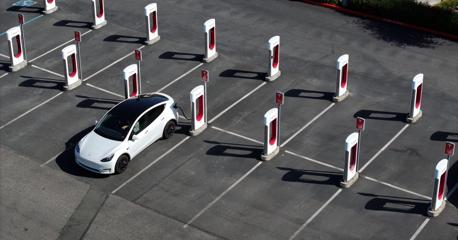

[Tesla vehicles kept crashing even after the Autopilot software updates](https://www.theverge.com/2024/5/7/24151077/tesla-autopilot-nhtsa-recall-crash-data-request) - The Verge

___

Usual Real Madrid bullshit. So ridic. Kinda wanted PSG v Bayern, Mbappé v Kane.

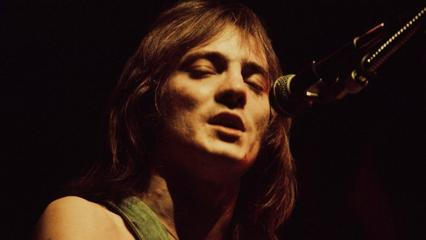

[Battle brews over AI-generated Steve Marriott](https://variety.com/2024/music/news/steve-marriott-children-fight-stop-ai-generated-songs-small-faces-humble-pie-1235996140/amp/) - Variety

___

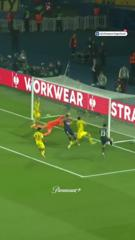

[time for Real Madrid vs. Man City ... here's a compilation of PSG hitting the post against BVB, and Mbappé asked who he will root for in today's game. how French is that. (even though he's tipped to move to Real Madrid. www.youtube.com/watch?v=zK9I...](https://www.youtube.com/watch?v=zK9IeFRffc0) - YouTube

___

[SoftBank in talks to buy AI chip startup GraphCore.](https://www.reuters.com/markets/deals/softbank-talks-buy-ai-chipmaker-graphcore-bloomberg-reports-2024-05-08/)

___

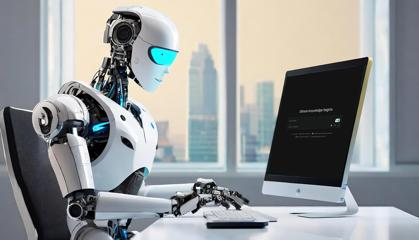

[Upend introduces new LLM-powered search app.](https://venturebeat.com/ai/new-ai-search-engine-upend-emerges-from-stealth-powered-by-100-llms/) - VentureBeat

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 10, 13, 11, 11, 118000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-09 03:31:08.782183
